In [1]:
from datetime import date, timedelta
import gc
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
input_dir = '../inputs/favorita-grocery-sales-forecasting'

df_train = pd.read_pickle('df_train_favorita.pkl')
df_test = pd.read_pickle('df_test_favorita.pkl')
items = pd.read_pickle('items_favorita.pkl')
stores = pd.read_pickle('stores_favorita.pkl')


df_2017 = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]
del df_train

promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
del promo_2017_test, promo_2017_train

df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

items = items.reindex(df_2017.index.get_level_values(1))

CPU times: total: 29.7 s
Wall time: 30.4 s


In [33]:
df_test

id  onpromotion
store_nbr item_nbr date                              
1         96995    2017-08-16  125497040        False
          99197    2017-08-16  125497041        False
          103501   2017-08-16  125497042        False
          103520   2017-08-16  125497043        False
          103665   2017-08-16  125497044        False
...                                  ...          ...
54        2132163  2017-08-31  128867499        False
          2132318  2017-08-31  128867500        False
          2132945  2017-08-31  128867501        False
          2132957  2017-08-31  128867502        False
          2134244  2017-08-31  128867503        False

[3370464 rows x 2 columns]

In [3]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[f'{t2017 + timedelta(days=i)}'].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [4]:
print("Preparing dataset...")
t2017 = date(2017, 5, 31)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

stores_items = pd.DataFrame(index=df_2017.index)
test_ids = df_test[['id']]

items = items.reindex( stores_items.index.get_level_values(1) )

Preparing dataset...


In [59]:
get_timespan(df_2017, date(2017, 7, 26), 1, 1)

date                2017-07-25
store_nbr item_nbr            
1         96995       0.000000
          99197       0.000000
          103520      1.098612
          103665      1.386294
          105574      1.791759
...                        ...
54        2109909     0.000000
          2110456     2.564949
          2113343     0.000000
          2113914     2.484907
          2116416     0.000000

[167515 rows x 1 columns]

In [26]:
print("Training and predicting models...")
params = {
    'num_leaves': 31,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2', # rmse
    'num_threads': 4,
    'device': 'gpu',
}

Training and predicting models...


In [27]:
X_train.shape, y_train.shape

((1005090, 40), (1005090, 16))

Step 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5598
[LightGBM] [Info] Number of data points in the train set: 1005090, number of used features: 40
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (23.00 MB) transferred to GPU in 0.025703 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.039801
Training until validation scores don't improve for 125 rounds
[500]	training's l2: 0.301253	valid_1's l2: 0.293425
[1000]	training's l2: 0.297492	valid_1's l2: 0.292089
[1500]	training's l2: 0.294893	valid_1's l2: 0.291622
[2000]	training's l2: 0.292696	valid_1's l2: 0.291377
[2500]	training's l2: 0.290686	valid_1's l2: 0.291274
[3000]	training's l2: 0.288852	valid_1's l2: 0.291169
Did not meet e

[LightGBM] [Info] Start training from score 1.026112
Training until validation scores don't improve for 125 rounds
[500]	training's l2: 0.332085	valid_1's l2: 0.389759
[1000]	training's l2: 0.327507	valid_1's l2: 0.388616
[1500]	training's l2: 0.32441	valid_1's l2: 0.388046
Early stopping, best iteration is:
[1679]	training's l2: 0.323427	valid_1's l2: 0.387866
Step 9
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5598
[LightGBM] [Info] Number of data points in the train set: 1005090, number of used features: 40
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (23.00 MB) transferred to GPU in 0.024402 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.946872
Training until validation scores do

[LightGBM] [Info] Start training from score 0.951286
Training until validation scores don't improve for 125 rounds
[500]	training's l2: 0.356867	valid_1's l2: 0.371976
[1000]	training's l2: 0.35247	valid_1's l2: 0.370823
[1500]	training's l2: 0.349265	valid_1's l2: 0.370454
[2000]	training's l2: 0.346591	valid_1's l2: 0.370354
Early stopping, best iteration is:
[2248]	training's l2: 0.345364	valid_1's l2: 0.370324
Validation mse: 0.36179283725138944


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

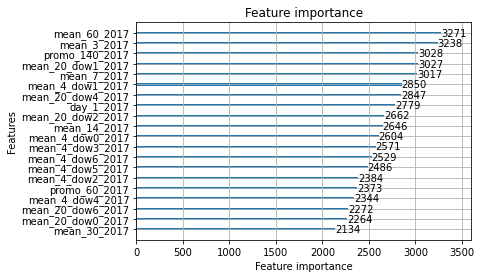

In [31]:
MAX_ROUNDS = 3000
val_pred = []
test_pred = []
cate_vars = []
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        # perishable (썩기쉬운) 물품은 가중치를 1.5배 준다.
        weight=pd.concat([items["perishable"]] * 6) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=125, verbose_eval=500
    )
#     print("\n".join(("%s: %.2f" % x) for x in sorted(
#         zip(X_train.columns, bst.feature_importance("gain")),
#         key=lambda x: x[1], reverse=True
#     )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

lgb.plot_importance(bst,max_num_features=20)


In [21]:
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb_max_3000.csv', float_format='%.4f', index=None)

Making submission...


NameError: name 'np' is not defined

In [22]:
submission

NameError: name 'submission' is not defined

# ensenble

In [2]:
import pandas as pd

In [50]:
first = pd.read_csv('./lstm_custum(small)_scaler_means.csv')

In [51]:
second = pd.read_csv('./lgb.csv')

In [52]:
first

,id,unit_sales
0,125497040,0.2188
1,125497041,0.4309
2,125497042,0.0000
3,125497043,1.2259
4,125497044,1.9041
...,...,...
3370459,128867499,0.0000
3370460,128867500,0.0000
3370461,128867501,0.0000
3370462,128867502,0.0000


In [53]:
second

,id,unit_sales
0,125497040,0.1876
1,125497041,0.2992
2,125497042,0.0000
3,125497043,0.9889
4,125497044,1.8322
...,...,...
3370459,128867499,0.0000
3370460,128867500,0.0000
3370461,128867501,0.0000
3370462,128867502,0.0000


In [54]:
ensenble = first

In [55]:
ensenble.unit_sales = round((0.6*first.unit_sales + 0.4*second.unit_sales), 4)

In [56]:
ensenble.to_csv('./ensenble_v1.csv', index= False)

In [57]:
ensenble

,id,unit_sales
0,125497040,0.2063
1,125497041,0.3782
2,125497042,0.0000
3,125497043,1.1311
4,125497044,1.8753
...,...,...
3370459,128867499,0.0000
3370460,128867500,0.0000
3370461,128867501,0.0000
3370462,128867502,0.0000
